In [1]:
import warnings
warnings.filterwarnings('ignore')

# data processing
import pandas as pd
import numpy as np

# image processing
from PIL import Image

# data visualization
import matplotlib.pyplot as plt
import seaborn as sn

# tf and keras
import tensorflow as tf
import keras
from keras.models import Sequential, Model, load_model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose, Dropout, BatchNormalization
from keras.layers.core import Dense, Activation, Flatten
from keras.optimizers import SGD, Adam
from keras.utils import plot_model
from keras.callbacks import ModelCheckpoint
from keras import backend as K

# dataset processing, ml models and metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import scipy
import sys

Using TensorFlow backend.


In [2]:
%matplotlib inline

In [3]:
pd.set_option('display.max_rows',None)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
dir_ = 'HASYv2/'
model_dir = 'trained_models/'
data_dir = 'data/'
K.set_image_data_format('channels_first')

---
---
# Functions

In [5]:
def read_csv(path):
    return pd.read_csv(data_dir + path)

#### Image Processing

In [6]:
# Image Preprocessing
def remove_transparency(im, bg_colour=(255, 255, 255)):

    # Only process if image has transparency 
    if im.mode in ('RGBA', 'LA') or (im.mode == 'P' and 'transparency' in im.info):

        # Need to convert to RGBA if LA format due to a bug in PIL 
        alpha = im.convert('RGBA').split()[-1]

        # Create a new background image of our matt color.
        # Must be RGBA because paste requires both images have the same format

        bg = Image.new("RGBA", im.size, bg_colour + (255,))
        bg.paste(im, mask=alpha)
        return bg

    else:
        return im

def change_to_bw(im):
    for i in range(im.shape[0]):
        for j in range(im.shape[1]):
            if im[i][j] > 191.25:
                im[i][j] = 0.0
            else:
                im[i][j] = 255.0
    return im
    
def preprocess_img(path):
    # Open Image
    im = Image.open(dir_ + path)
    
    # Resize image to 32 by 32
    if im.size != (32,32):
        im = im.resize((32,32))
        
    # Convert image to a single greyscale channel
    im = remove_transparency(im).convert('L')
    
    # Convert image to numpy array
    I = np.array(im)
    
    #Close image
    im.close()
    I = change_to_bw(I)
    return I



#### Dataset Preprocessing and Postprocessing

In [7]:
def populate_images(dataset):
    temp = []
    for i in range(len(dataset)):
        if i % 10000 == 0:  
            print(i)
        path = dataset.iloc[i]['path']
        pathsplit = path.split('/')
        if len(pathsplit) > 2:
            path = '/'.join([pathsplit[-2],pathsplit[-1]])
        img = preprocess_img(path)
        temp.append(img)
    dataset['img'] = [i for i in temp]
    return dataset

def convert_to_one_hot_encode(data, no_categories):
    data = np.array(data).reshape(-1)
    print('len of dataset', len(data))
    return np.eye(no_categories)[data]

# to process output to the value
# returns a list with all the categories with more than 50% accuracy
def one_hot_encode_to_char(arr, threshold=0.5, get_max=True):
    result = []
    val = 0
    for i in range(len(arr)):
        if arr[i] >= threshold:
            result.append((val, arr[i]))
        val +=1
    _max = []
    high = 0
    if get_max:
        for i in result:
            if i[1] > high:
                _max = [i[0]]
                high = i[1]
        return _max
    else:
        return [i[0] for i in result]

def convert_pred_list_ohe_to_labels(pred_data, threshold=0.5, get_max=True):
    result = []
    for i in range(len(pred_data)):
        val = one_hot_encode_to_char(pred_data[i], threshold=threshold, get_max=get_max)
        if len(val) > 0:
            if get_max == True:
                result.append(val[0])
            else:
                result.append(val)
        else:
            result.append(None)
            print(":( :( :(")
    return result

#### Dataset Splitting

In [8]:
# Stratified Train Test Split (new function)
def get_df_split(ds, stratify_col, test_size=0.2):
    _train, _test = train_test_split(ds, test_size=test_size, stratify=ds[stratify_col])
    return _train, _test

# function to split whole dataset at once (old function)
def gen_x_y_train_test_stratified_1df(dataset, input_shape, test_size=0.2):
    x = np.array(list(dataset['img']))
    y = np.array(list(dataset['symbol_id_ohe']))
    x = x.reshape((x.shape[0],1,input_shape[1],input_shape[2]))
    # Normalize data to 0-1
    x = x.astype("float32") / 255.0
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=test_size,  stratify=y)
    return X_train, X_test, y_train, y_test

# function to process already split data
def process_x_y_train_test_stratified_2df(_tr, _ts, input_shape):
    # train df
    X_train = np.array(list(_tr['img']))
    y_train = np.array(list(_tr['symbol_id_ohe']))
    X_train = X_train.reshape((X_train.shape[0],1,input_shape[1],input_shape[2]))
    # Normalize data to 0-1
    X_train = X_train.astype("float32") / 255.0
    # test df
    X_test = np.array(list(_ts['img']))
    y_test = np.array(list(_ts['symbol_id_ohe']))
    X_test = X_test.reshape((X_test.shape[0],1,input_shape[1],input_shape[2]))
    # Normalize data to 0-1
    X_test = X_test.astype("float32") / 255.0
    
    return X_train, X_test, y_train, y_test

#### Dataset metrics

In [9]:
# generate label counts for dataframe and list
def get_label_count_df(df_train, df_test, sym_list):
    train_labels_count = {}
    test_labels_count = {}
    perc_labels_count = {}
    for i in sym_list:
        train_labels_count[i] = 0
        test_labels_count[i] = 0
    for i in range(len(df_train)):
        train_labels_count[df_train.loc[i,'symbol_id']] += 1
    for i in range(len(df_test)):
        test_labels_count[df_test.loc[i,'symbol_id']] += 1
    for i in sym_list:
        perc = (train_labels_count[i] / (train_labels_count[i] + test_labels_count[i])) * 100
        perc_labels_count[i] = (train_labels_count[i], test_labels_count[i], round(perc,2))
    return perc_labels_count

def get_label_count_list(lst_data, sym_list):
    labels_count = {}
    for i in sym_list:
        labels_count[i] = 0
    for i in range(len(lst_data)):
        j = one_hot_encode_to_char(lst_data[i])[0]
        labels_count[j] += 1
    return labels_count

### Convolutional Neural Networks

In [10]:
# CNN without Batch Normalization
def get_layers(input_shape, data_format, classes):
    return [
        Conv2D(25, (5, 5), padding='same', data_format=data_format, input_shape=input_shape),
        Activation('relu'),
        MaxPooling2D(pool_size=(2,2), strides=(2,2)),
        
        Conv2D(50, (3, 3), padding='same', data_format=data_format),
        Activation('relu'),
        MaxPooling2D(pool_size=(2,2), strides=(2,2)),
                
        Conv2D(100, (2,2), padding='same', data_format=data_format),
        Activation('relu'),
        MaxPooling2D(pool_size=(2,2), strides=(2,2)),
        
        Conv2D(200, (2,2), padding='same', data_format=data_format),
        Activation('relu'),
        MaxPooling2D(pool_size=(2,2), strides=(2,2)),
        
        Flatten(),
        Dense(3200),
        Activation('relu'),
        
        Dense(1600),
        Activation('relu'),
        
        Dense(classes),
        Activation('softmax'),
    ]

def create_network_1(input_shape, data_format, classes):
    model = Sequential()
    layers = get_layers(input_shape, data_format, classes)
    for i in layers:
        model.add(i)
    return model                

In [11]:
# CNN with Batch Normalization
def get_layers_bn(input_shape, data_format, classes):
    return [
        Conv2D(25, (5, 5), padding='same', data_format=data_format, input_shape=input_shape),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(2,2), strides=(2,2)),
        
        Conv2D(50, (3, 3), padding='same', data_format=data_format),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(2,2), strides=(2,2)),
                
        Conv2D(100, (2,2), padding='same', data_format=data_format),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(2,2), strides=(2,2)),
        
        Conv2D(200, (2,2), padding='same', data_format=data_format),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(2,2), strides=(2,2)),
        
        Flatten(),
        Dense(3200),
        Activation('relu'),
        
        Dense(1600),
        Activation('relu'),
        
        Dense(classes),
        Activation('softmax'),
    ]

def create_network_2(input_shape, data_format, classes):
    model = Sequential()
    layers = get_layers_bn(input_shape, data_format, classes)
    for i in layers:
        model.add(i)
    return model                

#### Metrics

In [12]:
def t_test(test_x, test_y, models, sym2latex_dict):
    if len(models) < 0:
        raise ValueError("No models found in models variable")
    if len(test_x) != len(test_y):
        raise ValueError("Varibales test_x and test_y are of different length")
    
    # convert test values from one hot encoded to label value
    y_true = []
    for i in range(len(test_y)):
        # print(one_hot_encode_to_char(res[i], threshold = 0.5, get_max=False))
        val = one_hot_encode_to_char(test_y[i], threshold = 0.9, get_max=True)
        if len(val) > 0:
            y_true.append(val[0])
        else:
            y_true.append(None)
            print(":(")
    no_models = len(models)
    cols = ['symbol','latex']
    preds = []
    # convert predictions from one hot encoded to label value
    for i in range(no_models):
        print("Predictng labels for Model "+str(i))
        cols.append('model'+str(i))
        
        res = models[i].predict(X_test)
        y_pred = []
        for j in range(len(res)):
            # print(one_hot_encode_to_char(res[i], threshold = 0.5, get_max=False))
            val = one_hot_encode_to_char(res[j], threshold = 0.05, get_max=True)
            if len(val) > 0:
                y_pred.append(val[0])
            else:
                y_pred.append(None)
                print(":(")
        preds.append(y_pred)
    print("Predictions Done")
    print("Comparing Results...")
    
    # perform t test
    t_test_result = pd.DataFrame(columns=cols)
    for i in range(len(y_true)):
        t_test_result.loc[i,'symbol'] = y_true[i]
        t_test_result.loc[i,'latex'] = sym2latex_dict[y_true[i]]
        for j in range(no_models):
            t_test_result.loc[i, 'model'+str(j)] = sym2latex_dict[preds[j][i]]
    print("Done")    
    return t_test_result

def create_t_test_report(test_res):
    models_names = list(test_res.columns.values[2:])
    res = pd.DataFrame(columns=['latex','total_count']+models_names)
    for i in range(len(symbols)):
        res.loc[i,'latex'] = symbols.loc[i,'latex']
        res.loc[i,'total_count'] = 0
        for j in models_names:
            res.loc[i,j] = 0
    for i in range(len(test_res)):
        res.loc[test_res.loc[i,'symbol'],'total_count'] += 1
        for j in models_names:
            if test_res.loc[i,'latex'] == test_res.loc[i,j]:
                res.loc[latex2sym[test_res.loc[i,j]],j] += 1
    for i in range(len(res)):
        for j in models_names:
            res.loc[i,j+'_acc'] = (res.loc[i,j]/res.loc[i,'total_count']) * 100
    return res

---
# LABELS

In [13]:
whole_dataset = read_csv('hasy-data-labels.csv')
print(whole_dataset.head())
print('-----------------')
print(whole_dataset.info())

                     path  symbol_id latex  user_id
0  hasy-data/v2-00000.png         31     A       50
1  hasy-data/v2-00001.png         31     A       10
2  hasy-data/v2-00002.png         31     A       43
3  hasy-data/v2-00003.png         31     A       43
4  hasy-data/v2-00004.png         31     A     4435
-----------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168233 entries, 0 to 168232
Data columns (total 4 columns):
path         168233 non-null object
symbol_id    168233 non-null int64
latex        168233 non-null object
user_id      168233 non-null int64
dtypes: int64(2), object(2)
memory usage: 5.1+ MB
None


In [14]:
# Read symbols for all classification classes
symbols = read_csv('symbols.csv')
print(symbols.head())
print('-----------------')
print(symbols.info())

   symbol_id latex  training_samples  test_samples
0         31     A               137            22
1         32     B                53             8
2         33     C               120            14
3         34     D                50             8
4         35     E                48             6
-----------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 369 entries, 0 to 368
Data columns (total 4 columns):
symbol_id           369 non-null int64
latex               369 non-null object
training_samples    369 non-null int64
test_samples        369 non-null int64
dtypes: int64(3), object(1)
memory usage: 11.6+ KB
None


---
---
# Dataset Preprocessing

##### Reset Symbol names to start from 0 and end at 368

In [15]:
# change name of previous symbol
symbols['old_symbol'] = symbols['symbol_id']
symbols = symbols.drop('symbol_id', axis=1)

# add new id according to index of character
symbols['new_id'] = symbols.index

# make a symbols dict that references each symbol_id to the new symbol
symbols_dict = {}
for i in range(len(symbols)):
    symbols_dict[symbols['old_symbol'][i]] = symbols['new_id'][i]

In [16]:
whole_dataset['symbol_id'] = [symbols_dict[i] for i in whole_dataset['symbol_id']]
symbols_list = np.array(whole_dataset['symbol_id']).reshape(-1)

In [20]:
symbols.to_csv(data_dir = "symbols_processed.csv")

#### Stratified Train Test Split

In [17]:
# RUN THIS CELL ONLY ONCE for creating the splits, 
# then load the saved csv's for both train and test splits
# train, test = get_df_split(whole_dataset, stratify_col='symbol_id', test_size=0.1)
# train = train.reset_index(drop=True)
# test = test.reset_index(drop=True)
# train.to_csv(dir_+'train.csv')
# test.to_csv(dir_+'test.csv')

In [18]:
# Use this cell to load csvs
train = read_csv('train.csv').drop(['Unnamed: 0'], axis=1).reset_index(drop=True)
test = read_csv('test.csv').drop(['Unnamed: 0'], axis=1).reset_index(drop=True)

In [19]:
train.head()

,path,symbol_id,latex,user_id
0,hasy-data/v2-15966.png,331,\mathds{R},16925
1,hasy-data/v2-152185.png,312,\mathcal{O},16925
2,hasy-data/v2-71601.png,125,\%,16925
3,hasy-data/v2-50153.png,93,\varphi,124916
4,hasy-data/v2-32919.png,68,\gamma,16925


In [20]:
test.head()

,path,symbol_id,latex,user_id
0,hasy-data/v2-91515.png,171,\approx,16925
1,hasy-data/v2-33217.png,68,\gamma,16925
2,hasy-data/v2-31253.png,67,\Sigma,16925
3,hasy-data/v2-113978.png,224,\uparrow,16925
4,hasy-data/v2-36827.png,72,\zeta,16925


In [21]:
# (train_count, test_count, percentage of train count to total)
labels_count = get_label_count_df(train, test, symbols_list)
print(labels_count)

{0: (143, 16, 89.94), 1: (55, 6, 90.16), 2: (121, 13, 90.3), 3: (52, 6, 89.66), 4: (49, 5, 90.74), 5: (50, 6, 89.29), 6: (106, 12, 89.83), 7: (58, 6, 90.62), 8: (90, 10, 90.0), 9: (94, 10, 90.38), 10: (86, 10, 89.58), 11: (100, 11, 90.09), 12: (108, 12, 90.0), 13: (95, 10, 90.48), 14: (76, 8, 90.48), 15: (65, 7, 90.28), 16: (60, 7, 89.55), 17: (75, 8, 90.36), 18: (57, 6, 90.48), 19: (50, 6, 89.29), 20: (53, 6, 89.83), 21: (50, 6, 89.29), 22: (56, 6, 90.32), 23: (49, 5, 90.74), 24: (50, 6, 89.29), 25: (59, 6, 90.77), 26: (959, 107, 89.96), 27: (120, 13, 90.23), 28: (106, 12, 89.83), 29: (112, 12, 90.32), 30: (108, 12, 90.0), 31: (55, 6, 90.16), 32: (70, 8, 89.74), 33: (90, 10, 90.0), 34: (68, 7, 90.67), 35: (109, 12, 90.08), 36: (81, 9, 90.0), 37: (1380, 153, 90.02), 38: (2341, 260, 90.0), 39: (1018, 113, 90.01), 40: (3060, 340, 90.0), 41: (1011, 112, 90.03), 42: (77, 9, 89.53), 43: (51, 6, 89.47), 44: (60, 7, 89.55), 45: (52, 6, 89.66), 46: (57, 6, 90.48), 47: (59, 7, 89.39), 48: (50, 

#### One Hot Encode labels

In [22]:
no_categories = 369
train_one_hot_symbols = convert_to_one_hot_encode(train['symbol_id'], no_categories)
test_one_hot_symbols = convert_to_one_hot_encode(test['symbol_id'], no_categories)

len of dataset 151409
len of dataset 16824


In [23]:
# whole_dataset['symbol_id_ohe'] = [list(one_hot_symbols[i]) for i in range(len(whole_dataset))]
train['symbol_id_ohe'] = [list(train_one_hot_symbols[i]) for i in range(len(train))]
test['symbol_id_ohe'] = [list(test_one_hot_symbols[i]) for i in range(len(test))]

In [24]:
train = populate_images(train)
test = populate_images(test)

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
0
10000


In [25]:
train.head()

,path,symbol_id,latex,user_id,symbol_id_ohe,img
0,hasy-data/v2-15966.png,331,\mathds{R},16925,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0, 0, 0, 0, 255, 255, 255, 255, 255, 255, 25..."
1,hasy-data/v2-152185.png,312,\mathcal{O},16925,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, ..."
2,hasy-data/v2-71601.png,125,\%,16925,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,hasy-data/v2-50153.png,93,\varphi,124916,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,hasy-data/v2-32919.png,68,\gamma,16925,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [26]:
test.head()

,path,symbol_id,latex,user_id,symbol_id_ohe,img
0,hasy-data/v2-91515.png,171,\approx,16925,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,hasy-data/v2-33217.png,68,\gamma,16925,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0, 0, 0, 0, 0, 255, 255, 0, 0, 0, 0, 0, 0, 0..."
2,hasy-data/v2-31253.png,67,\Sigma,16925,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0, 0, 0, 255, 255, 255, 255, 255, 255, 255, ..."
3,hasy-data/v2-113978.png,224,\uparrow,16925,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255..."
4,hasy-data/v2-36827.png,72,\zeta,16925,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 25..."


---
---
# CONVOLUTIONAL NEURAL NETWORKS

#### HYPERPARAMETERS

In [27]:
smooth = 1

# define the channels location
data_format = 'channels_first'

# number of classification labels/classes
classes = 369

# input shape of dataset
input_shape = (1, 32, 32)
print("CNN Input Shape is", input_shape)

# optimizer
lr = 0.001
optimizer = SGD(lr=lr)

# loss function
loss = 'categorical_crossentropy'

batch_size = 512
epochs = 200

CNN Input Shape is (1, 32, 32)


### Model with Stratified Train Test Split Dataset

In [28]:
# old method
# X_train, X_test, y_train, y_test = gen_x_y_train_test_stratified_1df(whole_dataset, input_shape, test_size=0.2)
# train_labels_count = get_label_count_list(y_train, symbols_list)
# test_labels_count = get_label_count_list(y_test, symbols_list)
# -----------------------------------
# new 
X_train, X_test, y_train, y_test = process_x_y_train_test_stratified_2df(train, test, input_shape=input_shape)

In [29]:
# create network
model = create_network_2(input_shape, data_format, classes)
# compile network
model.compile(loss=loss, optimizer=optimizer, metrics = ['accuracy'])

In [30]:
# Model Summary
print(model.summary())
#plot_model(model, to_file=dir_+'model.png')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 25, 32, 32)        650       
_________________________________________________________________
batch_normalization_1 (Batch (None, 25, 32, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 25, 32, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 16, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 16, 16)        11300     
_________________________________________________________________
batch_normalization_2 (Batch (None, 50, 16, 16)        64        
_________________________________________________________________
activation_2 (Activation)    (None, 50, 16, 16)       

In [31]:
# Fit dataset
epochs = 300
model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=batch_size, epochs=epochs, verbose=1)
model.save(model_dir+'hasyv2model41.h5')
print("Training completed on 02/16")

Train on 151409 samples, validate on 16824 samples
Epoch 1/300
151409/151409 [==============================] - 31s 204us/step - loss: 5.5744 - acc: 0.0363 - val_loss: 5.3306 - val_acc: 0.0701
Epoch 2/300
151409/151409 [==============================] - 26s 172us/step - loss: 5.1936 - acc: 0.0835 - val_loss: 5.0596 - val_acc: 0.0942
Epoch 3/300
151409/151409 [==============================] - 26s 172us/step - loss: 4.9354 - acc: 0.1132 - val_loss: 4.8104 - val_acc: 0.1267
Epoch 4/300
151409/151409 [==============================] - 26s 174us/step - loss: 4.6738 - acc: 0.1569 - val_loss: 4.5473 - val_acc: 0.1839
Epoch 5/300
151409/151409 [==============================] - 26s 174us/step - loss: 4.3923 - acc: 0.2093 - val_loss: 4.2558 - val_acc: 0.2411
Epoch 6/300
151409/151409 [==============================] - 26s 173us/step - loss: 4.0871 - acc: 0.2665 - val_loss: 3.9388 - val_acc: 0.2908
Epoch 7/300
151409/151409 [==============================] - 26s 173us/step - loss: 3.7665 - acc:

---
---
## Metrics

In [32]:
# to load model use
model = load_model(model_dir+'hasyv2model41.h5')

In [33]:
res = model.predict(X_test)

In [37]:
# convert predictions from one hot encoded to label value
y_pred = convert_pred_list_ohe_to_labels(res, threshold=0.05, get_max=True)

In [38]:
# convert test values from one hot encoded to label value
y_true = convert_pred_list_ohe_to_labels(y_test, threshold=0.9, get_max=True)

#### Confusion Matrix

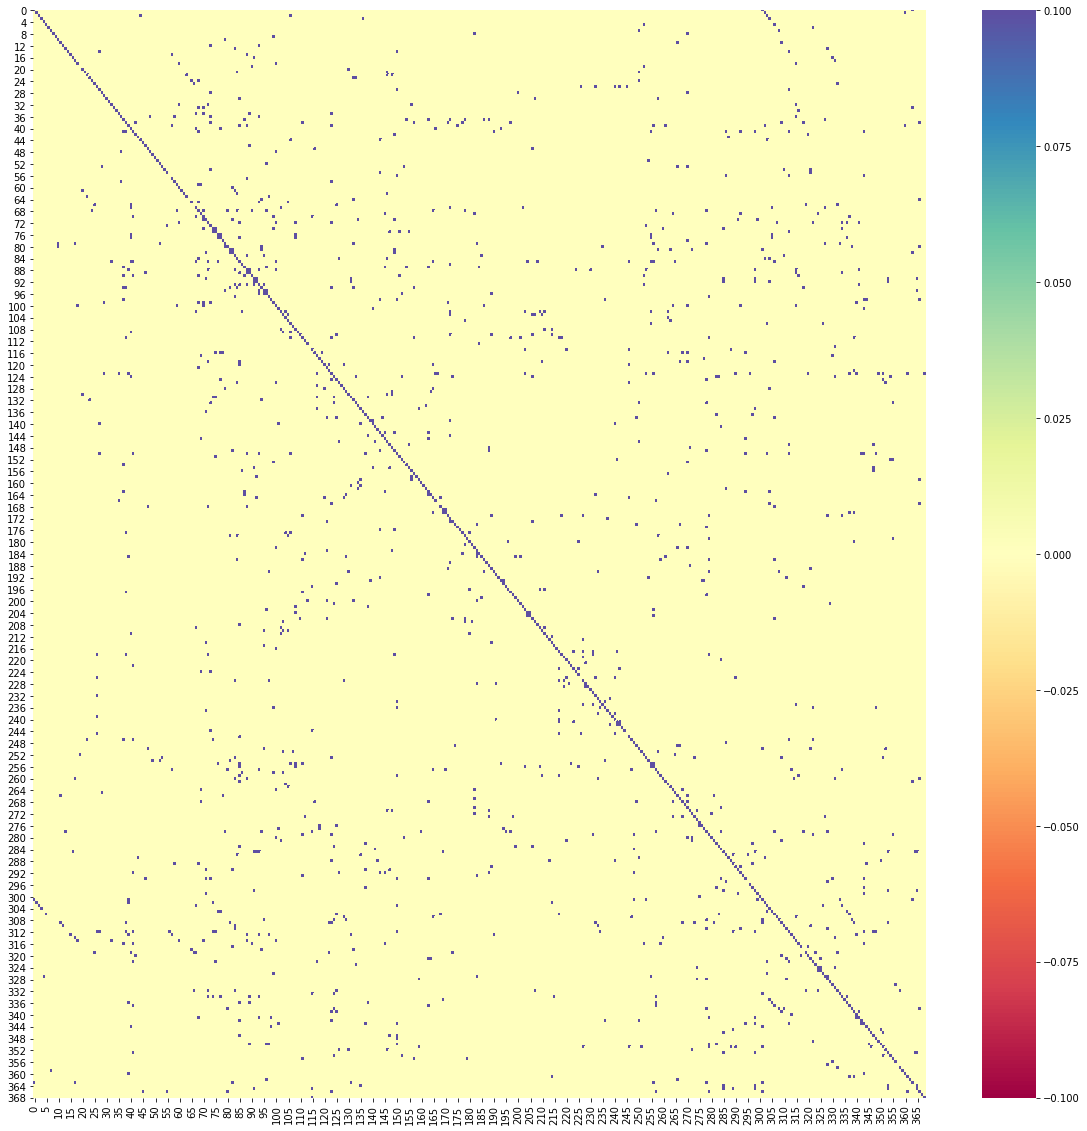

In [39]:
# Spectral Color Map used: Violet means 1, Red means -1 and Yellow means 0
cfs10 = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(20,20))
sn.heatmap(cfs10, cmap="Spectral", robust=True)

#### Multiclass Precision, Recall and Accuracy

In [40]:
cr10 = classification_report(y_true, y_pred, digits=4)
print(cr10)

              precision    recall  f1-score   support

           0     0.6667    0.6250    0.6452        16
           1     0.7500    0.5000    0.6000         6
           2     0.8750    0.5385    0.6667        13
           3     0.5000    0.5000    0.5000         6
           4     0.8333    1.0000    0.9091         5
           5     0.8000    0.6667    0.7273         6
           6     1.0000    0.9167    0.9565        12
           7     0.8000    0.6667    0.7273         6
           8     1.0000    0.4000    0.5714        10
           9     1.0000    0.8000    0.8889        10
          10     0.7500    0.9000    0.8182        10
          11     0.6000    0.5455    0.5714        11
          12     0.8333    0.8333    0.8333        12
          13     0.8750    0.7000    0.7778        10
          14     1.0000    0.2500    0.4000         8
          15     0.6250    0.7143    0.6667         7
          16     0.7500    0.4286    0.5455         7
          17     0.6000    

#### T Test

In [41]:
sym2latex = {i.Index : i.latex for i in symbols.itertuples()}
latex2sym = {v: k for k, v in sym2latex.items()}

In [42]:
ms = ['hasyv2model41.h5']
models = [load_model(model_dir+z) for z in ms]

In [43]:
ms = [
    'hasyv2model.h5',
    'hasyv2model2.h5',
    'hasyv2model3.h5',
    'hasyv2model_stratified_kfold4.h5',
    'hasyv2model_stratified_kfold5.h5',
    'hasyv2model_stratified_kfold6.h5',
    'hasyv2model_stratified_kfold7.h5',
    'hasyv2model21.h5',
    'hasyv2model.h5'
     ]
models = [load_model(model_dir+z) for z in ms]

In [45]:
ttest = t_test(X_test, y_test, models=models, sym2latex_dict=sym2latex)
ttest.head()

Predictng labels for Model 0
Predictions Done
Comparing Results...
Done


,symbol,latex,model0
0,171,\approx,\approx
1,68,\gamma,\gamma
2,67,\Sigma,\sum
3,224,\uparrow,\uparrow
4,72,\zeta,\zeta


In [46]:
t_test_report = create_t_test_report(ttest)
t_test_report.head()

,latex,total_count,model0,model0_acc
0,A,16,10,62.500000
1,B,6,3,50.000000
2,C,13,7,53.846154
3,D,6,3,50.000000
4,E,5,5,100.000000


### Convolutional Neural Networks
* CNN1: CNN with two convolutional and two dense layers
* CNN2: CNN with three convolutional and three dense layers
* CNN3: CNN with three convolutional and three dense layers with Batch Normalization

### Models
* model0: CNN1 on whole dataset
* model1: CNN1 with random split on dataset
* model2: CNN1 with stratified split on dataset
* model3: CNN1 with K Fold cross validation
* model4: CNN1 with K Fold cross vlidation
* model5: CNN1 with K Fold cross validation
* model6: CNN1 with K Fold cross validation
* model7: CNN2 with stratified split on dataset
* model8: CNN3 with stratified split on dataset

In [47]:
t_test_report

,latex,total_count,model0,model0_acc
0,A,16,10,62.500000
1,B,6,3,50.000000
2,C,13,7,53.846154
3,D,6,3,50.000000
4,E,5,5,100.000000
5,F,6,4,66.666667
6,G,12,11,91.666667
7,H,6,4,66.666667
8,I,10,4,40.000000
9,J,10,8,80.000000
